# **Model Tuning I**
Initial model parameters:
- Hidden size of 256
- Number of attention heads: 8
- Number of layers: 4

The default model has a MLP ratio of 4 and no dropout.

In this section, the focus is on experimenting with the feedforward dimension (by adjusting the MLP ratio) and adding dropout inside the attention and MLP sub-layers (between 0.1 and 0.4).

**Objectives**
- To find the best model with `mlp_ratio` and `dropout`.
- Explore sinusoidal P.E as an alternative P.E to learned P.E

The metrics used for evaluation include training time and validation loss, specifically the averaged cross-entropy loss over all tokens.

**Disclaimer**
- With GPU usage in mind, MLP ratio is constrained to 5 and below.
- Dropout affects training behaviour, not the number of parameters. No constraint is exercised here.






# **Importing**

Import data, libraries and functions

In [ ]:
# Import all modules and functions
import scripts.functions as functions
from functions import *

In [ ]:
# Import data
train_text_int = np.load("train_text_int.npy")
test_text_int = np.load("test_text_int.npy")

In [ ]:
# Import transformer model for testing with dropout, mlp ratio
import models.modified_transformer as transformer_mod

In [ ]:
# Import in model params
import yaml

with open("./conf/config1.yml", "r") as f:
    cfg = yaml.safe_load(f)
    print(cfg)

# model parameters
vocab_size = cfg['vocab_size']
d_model = cfg['d_model']
n_layers = cfg['n_layers']
n_heads = cfg['n_heads']
max_len = cfg['max_len']

# tunable parameters
mlp_ratio = cfg['mlp_ratio']
dropout = cfg['dropout']

lr = cfg['learning_rate']

{'vocab_size': 27, 'd_model': 256, 'n_layers': 4, 'n_heads': 8, 'max_len': 128, 'mlp_ratio': [2, 3, 4, 5], 'dropout': [0.1, 0.2, 0.3, 0.4], 'learning_rate': 0.001}


In [ ]:
# For model tuning, separate train_text_int into training and validation sets
print(len(train_text_int))

# 1/9 of the training set will be set aside for validation
val_text_int = train_text_int[-10_000_000:]
training_text_int = train_text_int[:80_000_000]
print(len(val_text_int))
print(len(training_text_int))

90000000
10000000
80000000


In [ ]:
# a single gradient update
def train_step(params, opt_state, x, y, tx):
    """
    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B_seq, B_tok) int array input tokens.
      y: (B_seq, B_tok) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients of loss w.r.t params (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: update params and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

### **Tuning MLP ratio**

Experiment with different `mlp_ratio` values without adding dropout ( `dropout` = 0.0)


In [ ]:
# Function to initialize basic Transformer model and its params
def create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len, mlp_ratio, dropout):
    model = transformer_mod.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len, mlp_ratio, dropout)

    # Create dummy input for initialization of batch size 1, seq length min(16, max_len)
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # Initialize the parameters and extracts the PyTree of params
    params = model.init({"params": key}, dummy)["params"]
    return model, params

In [ ]:
print(mlp_ratio)

dropout_init = 0.0

[2, 3, 4, 5]


In [ ]:
# Keep track of all results
val_loss_all = []
training_time_all = []

for ratio in mlp_ratio:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len, ratio, dropout_init)
    print(f"Transformer model initialized with a mlp_ratio of {ratio} without dropout.")

    tx = optax.adam(learning_rate=lr)
    # Initialize optimizer state for current params
    opt_state = tx.init(params)
    niter = 20_000
    B_seq, B_tok = 64, 32

    time_val_history = []
    loss_val_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    training_time_all.append(time_val_history)

Transformer model initialized with a mlp_ratio of 2 without dropout.
Transformer model initialized with a mlp_ratio of 3 without dropout.
Transformer model initialized with a mlp_ratio of 4 without dropout.
Transformer model initialized with a mlp_ratio of 5 without dropout.


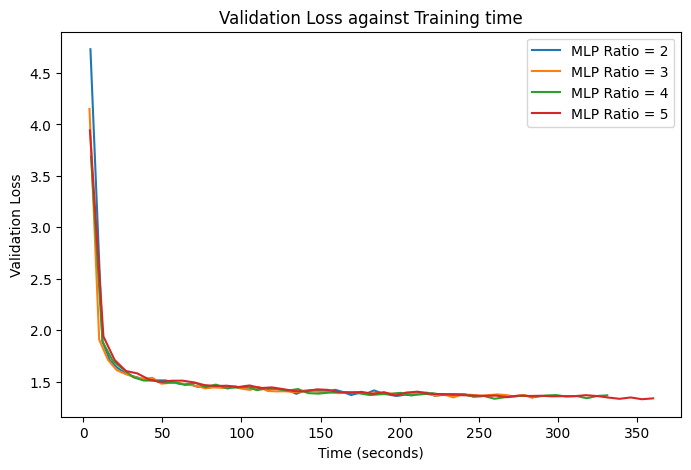

In [ ]:
plt.figure(figsize=(8,5))

for i in range(0, len(mlp_ratio)):
    plt.plot(training_time_all[i], val_loss_all[i], label = f"MLP Ratio = {mlp_ratio[i]}")

plt.xlabel("Time (seconds)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss against Training time")
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Compare the results
for i in range(0, len(mlp_ratio)):
    string = f"""
    For the transformer initialized with an MLP Ratio of {mlp_ratio[i]}:
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {training_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {training_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    For the transformer initialized with an MLP Ratio of 2:
    Final validation loss: 1.3596796989440918
    Total Training Time: 251.26293015480042
    Minimum validation loss: 1.3568851947784424 attained at 246.39746499061584 seconds
    

    For the transformer initialized with an MLP Ratio of 3:
    Final validation loss: 1.342824101448059
    Total Training Time: 283.8405251502991
    Minimum validation loss: 1.342824101448059 attained at 283.8405251502991 seconds
    

    For the transformer initialized with an MLP Ratio of 4:
    Final validation loss: 1.3677589893341064
    Total Training Time: 330.9989161491394
    Minimum validation loss: 1.334612250328064 attained at 259.82085728645325 seconds
    

    For the transformer initialized with an MLP Ratio of 5:
    Final validation loss: 1.3381986618041992
    Total Training Time: 359.9415683746338
    Minimum validation loss: 1.329866647720337 attained at 352.894681930542 seconds
    


### **Evaluation**

- **Plot results**: All the models' performance are very close. The larger the `mlp_ratio`, the longer the training time.
- **Final results** have shown that increasing MLP ratio allows the transformer to learn more patterns, as validation loss (referred to as the **minimum validation loss** here) decreases.
- **Decision** is to proceed with an MLP ratio of 4, even though the best performing MLP ratio is 5, the difference in minimum validation loss is very small (~0.005). Just like the previous experiment, increasing training time to accomodate a very small increase in performance is something that will not be pursued for future small experiments; only significant improvements in performance with somewhat proportional or less than proportional increases in training time are tolerated.



### **Tuning dropout**

Addition of `dropout` values between 0.1 and 0.4 to a model with the MLP ratio of 4.

In [ ]:
print(dropout)
best_mlp_ratio = 4

[0.1, 0.2, 0.3, 0.4]


In [ ]:
# Keep track of all results
val_loss_all = []
training_time_all = []

for drop in dropout:
    # Initialize the model architecture and params
    model, params = create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len, best_mlp_ratio, drop)
    print(f"Transformer model initialized with mlp_ratio of {best_mlp_ratio} with added dropout value of {drop}.")

    tx = optax.adam(learning_rate=lr)
    # Initialize optimizer state for current params
    opt_state = tx.init(params)

    niter = 20_000                    # reduced no of iterations for each model
    B_seq, B_tok = 64, 32             # sample a smaller no of sequences per batch, same no of tokens per seq

    time_start = time.time

    time_val_history = []
    loss_val_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    training_time_all.append(time_val_history)


Transformer model initialized with mlp_ratio of 4 with added dropout value of 0.1.
Transformer model initialized with mlp_ratio of 4 with added dropout value of 0.2.
Transformer model initialized with mlp_ratio of 4 with added dropout value of 0.3.
Transformer model initialized with mlp_ratio of 4 with added dropout value of 0.4.


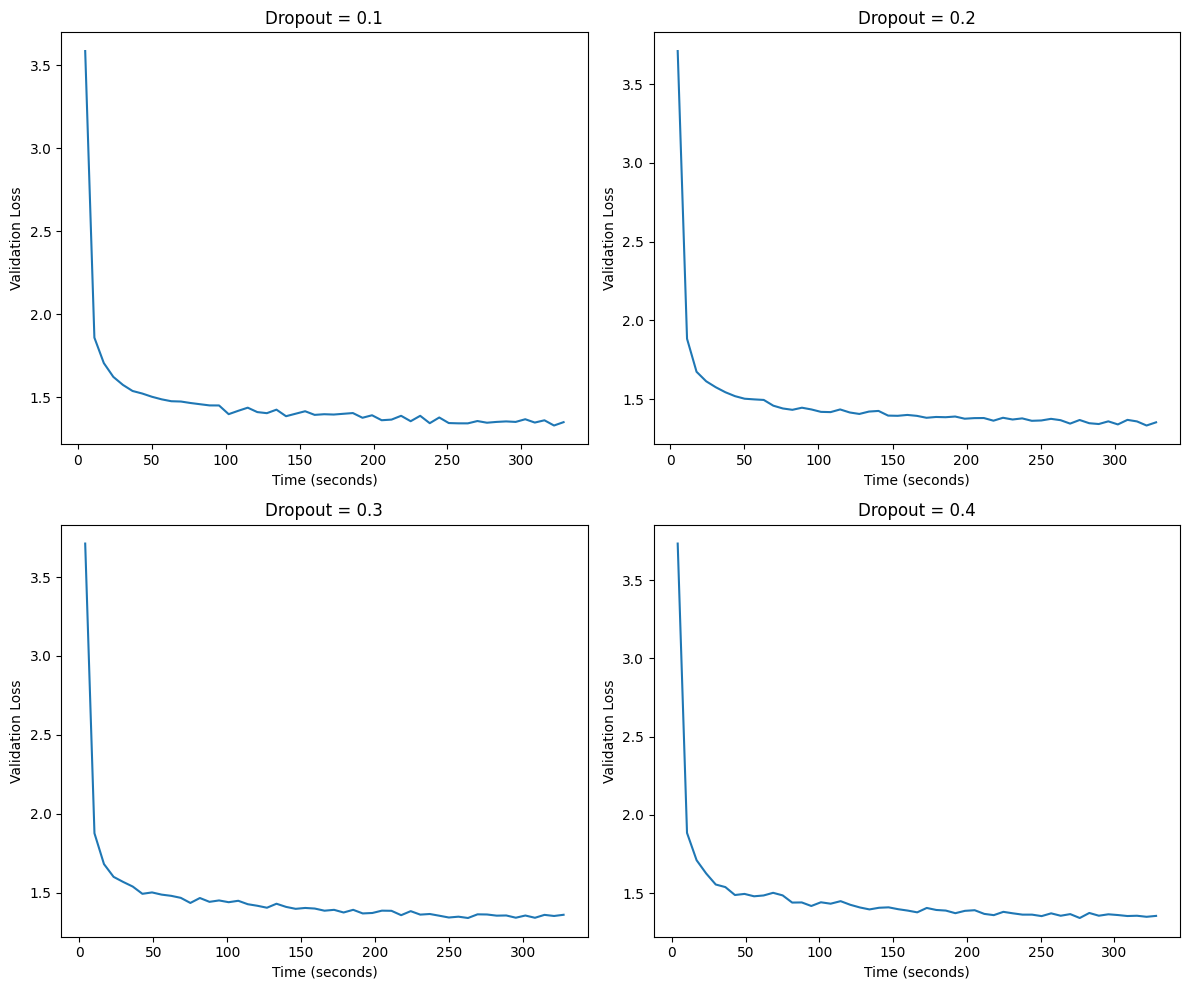

In [ ]:
plt.figure(figsize=(12, 10))

for i in range(len(dropout)):
    plt.subplot(2, 2, i + 1)
    plt.plot(training_time_all[i], val_loss_all[i])
    plt.xlabel("Time (seconds)")
    plt.ylabel("Validation Loss")
    plt.title(f"Dropout = {dropout[i]}")

plt.tight_layout()
plt.show()


In [ ]:
# Compare the results
for i in range(0, len(dropout)):
    string = f"""
    For the transformer initialized with a dropout of {dropout[i]}:
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {training_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {training_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    For the transformer initialized with a dropout of 0.1:
    Final validation loss: 1.3500231504440308
    Total Training Time: 328.5110399723053
    Minimum validation loss: 1.3299182653427124 attained at 322.03691124916077 seconds
    

    For the transformer initialized with a dropout of 0.2:
    Final validation loss: 1.353165864944458
    Total Training Time: 327.942409992218
    Minimum validation loss: 1.332960605621338 attained at 321.5130343437195 seconds
    

    For the transformer initialized with a dropout of 0.3:
    Final validation loss: 1.3604289293289185
    Total Training Time: 327.7294361591339
    Minimum validation loss: 1.340050458908081 attained at 263.01179242134094 seconds
    

    For the transformer initialized with a dropout of 0.4:
    Final validation loss: 1.3550941944122314
    Total Training Time: 328.2069354057312
    Minimum validation loss: 1.3416540622711182 attained at 276.4934492111206 seconds
    


### **Evaluation**

In contrast, the control model with an `mlp_ratio` of 4 and no dropout has a total training time of **331.00 seconds** and a minimum validation loss of **1.3346**.

- From the plots, all the models have very similar total training times and convergence rates.
- Final results show that the smaller dropout values have almost matching model performance, compared to the control setup.

Adding dropout, regardless of the value, introduces regularization to the attention heads. It is important to adopt a regularization technique, thus a dropout of 0.2 will be added as it also does not compromise model performance

### **Decision**
The values decided are `mlp_ratio` = 4 and `dropout` = 0.2. The model will adopt these values going forward.



# **Varying Positional Encodings**

The current model has learned positional encodings.

In the following section, the model will be initialized with sinusoidal P.Es. As sinusoidal P.Es help the model to possibly condition easier to the order of tokens for longer sequences, experiment with a growing sequence length.


In [ ]:
import yaml

with open("./conf/config2.yml", "r") as f:
    cfg = yaml.safe_load(f)
    print(cfg)

# model parameters
vocab_size = cfg['vocab_size']
d_model = cfg['d_model']
n_layers = cfg['n_layers']
n_heads = cfg['n_heads']
max_len = cfg['max_len']
mlp_ratio = cfg['mlp_ratio']
dropout = cfg['dropout']
lr = cfg['learning_rate']

{'vocab_size': 27, 'd_model': 256, 'n_layers': 4, 'n_heads': 8, 'max_len': 128, 'mlp_ratio': 4, 'dropout': 0.2, 'batch_size': 64, 'learning_rate': 0.001}


In [ ]:
# Import another transformer model specifically used for testing with P.E
import models.pos_encoding_transformer as positional_transformer

In [ ]:
# Initialize the model architecture and params
def create_pos_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len, mlp_ratio, dropout):
    model = positional_transformer.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len, mlp_ratio, dropout)

    # Create dummy input for initialization of batch size 1, seq length min(16, max_len)
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # Initialize the parameters and extracts the PyTree of params
    params = model.init({"params": key}, dummy)["params"]
    return model, params

Commented out portions of code for learned and RoPE in `pos_encoding_transformer.py` to test on sinusoidal positional encoding only.

Tuning of `B_tok` values. Growing sequence length may help the model generalize better, improving performance.

In [ ]:
# Increasing sequence length
T = [32, 48, 64, 80]

In [ ]:
# Keep track of all results
val_loss_all = []
training_time_all = []

for t in T:

    model, params = create_pos_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len, mlp_ratio, dropout)
    print(f"Transformer model initialized with sinusoidal positional encodings trained on sequence lengths of {t}.")

    tx = optax.adam(learning_rate=lr)
    # Initialize optimizer state for current params
    opt_state = tx.init(params)

    niter = 20_000
    B_seq, B_tok = 64, t

    time_start = time.time

    time_val_history = []
    loss_val_history = []
    time_start = time.time()
    for it in range(niter):
        batch = get_batch(training_text_int, B_seq, B_tok)
        input, target = batch[0], batch[1]
        params_new, opt_state_new, metrics = train_step(params, opt_state, input, target, tx)

        # update model weights and optimizer state
        params = params_new
        opt_state = opt_state_new

        # Evaluate on validation data periodically
        if it % (niter // 50) == 0 or it == niter - 1:
            time_since_start = time.time() - time_start
            # compute loss on validation set
            B_val, T_val = 1024, 32
            val_batch = get_batch(val_text_int, B_val, T_val)
            val_input, val_target = val_batch[0], val_batch[1]
            val_logits = model.apply({"params": params}, val_input)
            val_loss, val_metrics = loss_and_metrics(val_logits, val_target)
            loss_val_history.append(val_loss)
            time_val_history.append(time_since_start)

    val_loss_all.append(loss_val_history)
    training_time_all.append(time_val_history)


Transformer model initialized with sinusoidal positional encodings trained on sequence lengths of 32.
Transformer model initialized with sinusoidal positional encodings trained on sequence lengths of 48.
Transformer model initialized with sinusoidal positional encodings trained on sequence lengths of 64.
Transformer model initialized with sinusoidal positional encodings trained on sequence lengths of 80.


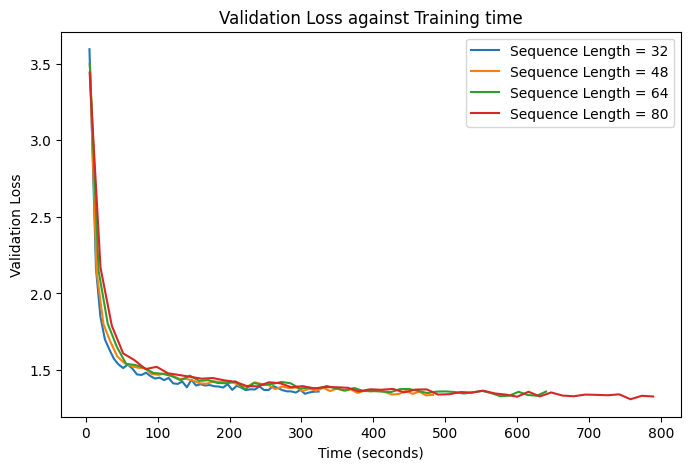

In [ ]:
plt.figure(figsize=(8,5))

for i in range(0, len(T)):
    plt.plot(training_time_all[i], val_loss_all[i], label = f"Sequence Length = {T[i]}")

plt.xlabel("Time (seconds)")
plt.ylabel("Validation Loss")
plt.title("Validation Loss against Training time")
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Compare the full training times and final validation losses of all models
for i in range(0, len(T)):
    string = f"""
    Model with sinusoidal P.E trained on sequence length {T[i]}:
    Final validation loss: {val_loss_all[i][-1]}
    Total Training Time: {training_time_all[i][-1]}
    Minimum validation loss: {min(val_loss_all[i])} attained at {training_time_all[i][val_loss_all[i].index(min(val_loss_all[i]))]} seconds
    """
    print(string)


    Model with sinusoidal P.E trained on sequence length 32:
    Final validation loss: 1.3592467308044434
    Total Training Time: 323.8582124710083
    Minimum validation loss: 1.3446122407913208 attained at 304.91529655456543 seconds
    

    Model with sinusoidal P.E trained on sequence length 48:
    Final validation loss: 1.3374630212783813
    Total Training Time: 483.16820096969604
    Minimum validation loss: 1.3341233730316162 attained at 473.65489053726196 seconds
    

    Model with sinusoidal P.E trained on sequence length 64:
    Final validation loss: 1.3590644598007202
    Total Training Time: 640.4290471076965
    Minimum validation loss: 1.3285555839538574 attained at 576.8918979167938 seconds
    

    Model with sinusoidal P.E trained on sequence length 80:
    Final validation loss: 1.3269307613372803
    Total Training Time: 789.4268808364868
    Minimum validation loss: 1.3090262413024902 attained at 757.99387383461 seconds
    


### **Evaluation**

Model performance improves as sequence length increases but total training time increases proportionately.

For reference, the control setup with learned positional encoding trained on a sequence length of 32 has a total training time of **327.94 seconds** and a minimum **validation loss of 1.333**.

When compared with the sinusoidal P.E trained on the same sequence length 32, the control has better performance. While longer sequence lengths improve performance of models with sinusoidal P.E, this can also be experimented with learned P.E, which will be done near the end of the project.
For now, learned P.E will be used.
